## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-11-17T00:00:00.0000000Z', 'time_period_end': '2023-11-18T00:00:00.0000000Z', 'time_open': '2023-11-17T00:04:14.0360000Z', 'time_close': '2023-11-17T15:37:56.7510000Z', 'price_open': 71, 'price_high': 71.65, 'price_low': 68.63, 'price_close': 68.63, 'volume_traded': 4513.93959639, 'trades_count': 574}, {'time_period_start': '2023-11-16T00:00:00.0000000Z', 'time_period_end': '2023-11-17T00:00:00.0000000Z', 'time_open': '2023-11-16T00:00:46.4580000Z', 'time_close': '2023-11-16T23:59:08.8220000Z', 'price_open': 74.07, 'price_high': 74.41, 'price_low': 69.97, 'price_close': 70.94, 'volume_traded': 10873.9187049, 'trades_count': 1075}, {'time_period_start': '2023-11-15T00:00:00.0000000Z', 'time_period_end': '2023-11-16T00:00:00.0000000Z', 'time_open': '2023-11-15T00:05:09.9990000Z', 'time_close': '2023-11-15T23:49:10.5200000Z', 'price_open': 70.82, 'price_high': 74.28, 'price_low': 70.62, 'price_close': 74.07, 'volume_traded': 3629.17141649, 'trades_count': 706},

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-11-17T00:00:00.0000000Z,2023-11-18T00:00:00.0000000Z,2023-11-17T00:04:14.0360000Z,2023-11-17T15:37:56.7510000Z,71.00,71.65,68.63,68.63,4513.939596,574
1,2023-11-16T00:00:00.0000000Z,2023-11-17T00:00:00.0000000Z,2023-11-16T00:00:46.4580000Z,2023-11-16T23:59:08.8220000Z,74.07,74.41,69.97,70.94,10873.918705,1075
2,2023-11-15T00:00:00.0000000Z,2023-11-16T00:00:00.0000000Z,2023-11-15T00:05:09.9990000Z,2023-11-15T23:49:10.5200000Z,70.82,74.28,70.62,74.07,3629.171416,706
3,2023-11-14T00:00:00.0000000Z,2023-11-15T00:00:00.0000000Z,2023-11-14T00:02:09.4790000Z,2023-11-14T23:56:36.2820000Z,71.32,72.52,68.01,70.61,7989.181924,1178
4,2023-11-13T00:00:00.0000000Z,2023-11-14T00:00:00.0000000Z,2023-11-13T00:00:07.2400000Z,2023-11-13T23:58:33.2450000Z,74.89,76.75,70.50,71.23,13418.893816,1915


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


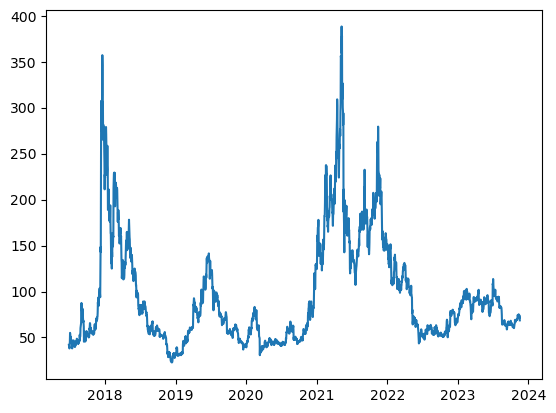

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2284, 30), (2284,), (2284,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1827, 30), (1827,), (228, 30), (228,), (229, 30), (229,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100


2023-11-17 10:39:45.149781: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


58/58 [==============================] - 1s 9ms/step - loss: 5.0770 - mean_absolute_error: 1.6779 - val_loss: 0.0628 - val_mean_absolute_error: 0.2143
Epoch 2/100
58/58 [==============================] - 0s 5ms/step - loss: 0.3084 - mean_absolute_error: 0.4795 - val_loss: 0.0795 - val_mean_absolute_error: 0.2345
Epoch 3/100
58/58 [==============================] - 0s 5ms/step - loss: 0.1494 - mean_absolute_error: 0.3077 - val_loss: 0.0153 - val_mean_absolute_error: 0.0954
Epoch 4/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0253 - mean_absolute_error: 0.1184 - val_loss: 0.0071 - val_mean_absolute_error: 0.0668
Epoch 5/100
58/58 [==============================] - 0s 5ms/step - loss: 0.0199 - mean_absolute_error: 0.1041 - val_loss: 0.0065 - val_mean_absolute_error: 0.0629
Epoch 6/100
58/58 [==============================] - 0s 6ms/step - loss: 0.0173 - mean_absolute_error: 0.0986 - val_loss: 0.0159 - val_mean_absolute_error: 0.1125
Epoch 7/100
58/58 [===============

58/58 [==============================] - 0s 1ms/step


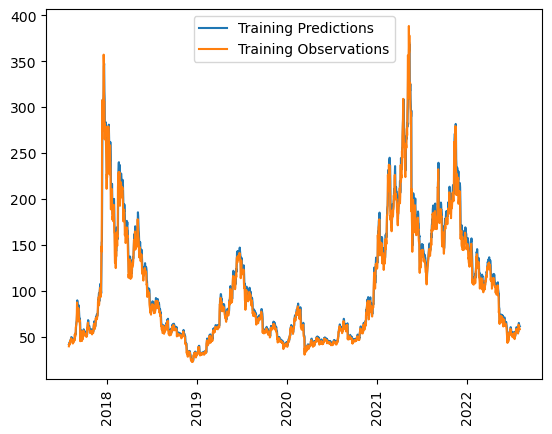

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0030050710774958134
Val MAE: 0.044309698045253754


8/8 [==============================] - 0s 2ms/step


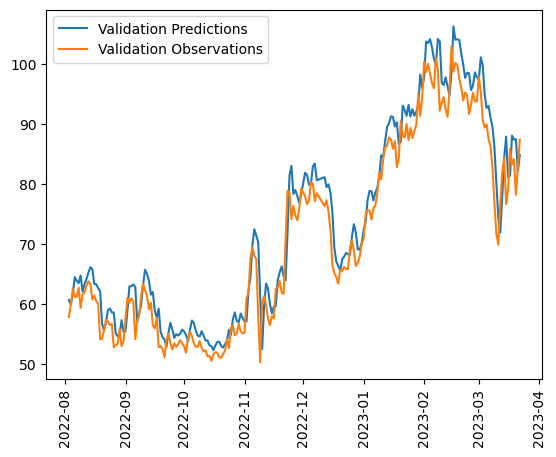

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0027203436475247145
Test MAE: 0.04171282425522804


8/8 [==============================] - 0s 2ms/step


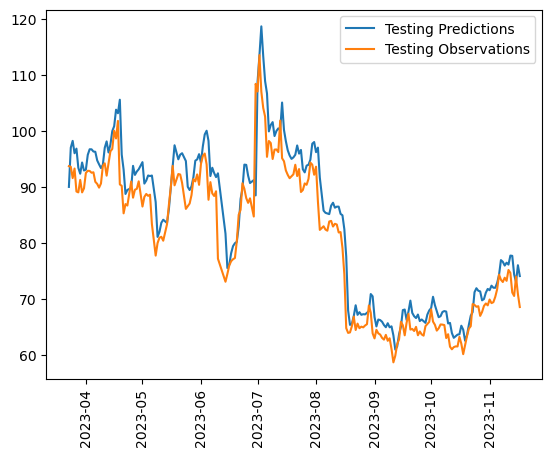

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.9012373910343793


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((890,),
 (890, 30),
 (890,),
 (137,),
 (137, 30),
 (137,),
 (115,),
 (115, 30),
 (115,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
58/58 [==============================] - 1s 8ms/step - loss: 6.0199 - mean_absolute_error: 1.9183 - val_loss: 0.0445 - val_mean_absolute_error: 0.1892
Epoch 2/300
58/58 [==============================] - 0s 6ms/step - loss: 0.3378 - mean_absolute_error: 0.4951 - val_loss: 0.1211 - val_mean_absolute_error: 0.2927
Epoch 3/300
58/58 [==============================] - 0s 5ms/step - loss: 0.1751 - mean_absolute_error: 0.3335 - val_loss: 0.0580 - val_mean_absolute_error: 0.2168
Epoch 4/300
58/58 [==============================] - 0s 5ms/step - loss: 0.0422 - mean_absolute_error: 0.1564 - val_loss: 0.0078 - val_mean_absolute_error: 0.0693
Epoch 5/300
58/58 [==============================] - 0s 5ms/step - loss: 0.0265 - mean_absolute_error: 0.1200 - val_loss: 0.0113 - val_mean_absolute_error: 0.0864
Epoch 6/300
58/58 [==============================] - 0s 5ms/step - loss: 0.0194 - mean_absolute_error: 0.1019 - val_loss: 0.0066 - val_mean_absolute_error: 0.0654
Epoch 7/300
58/58 [===

58/58 [==============================] - 0s 2ms/step


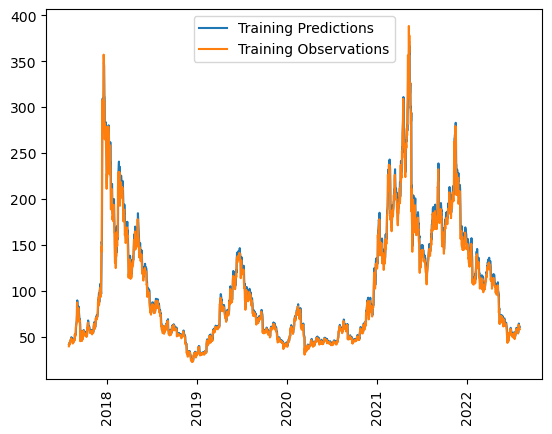

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0028012068942189217
Val MAE: 0.03978027403354645


5/5 [==============================] - 0s 2ms/step


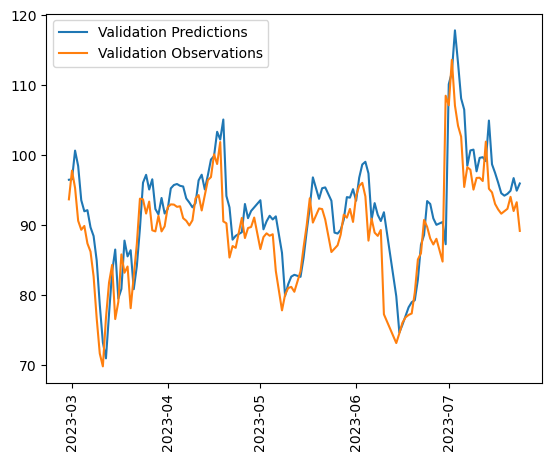

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0014395922189578414
Test MAE: 0.029415354132652283


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 2ms/step
R2 Score:  0.895857404777081


4/4 [==============================] - 0s 2ms/step


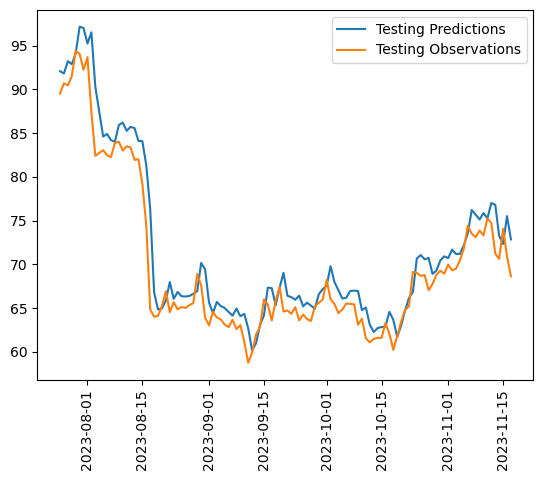

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 1s 16ms/step - loss: 22.7575 - mean_absolute_error: 4.7409 - val_loss: 19.7338 - val_mean_absolute_error: 4.4415
Epoch 2/300
28/28 [==============================] - 0s 6ms/step - loss: 20.9909 - mean_absolute_error: 4.5522 - val_loss: 18.4035 - val_mean_absolute_error: 4.2891
Epoch 3/300
28/28 [==============================] - 0s 6ms/step - loss: 19.4237 - mean_absolute_error: 4.3773 - val_loss: 16.7327 - val_mean_absolute_error: 4.0898
Epoch 4/300
28/28 [==============================] - 0s 6ms/step - loss: 17.4386 - mean_absolute_error: 4.1443 - val_loss: 14.4712 - val_mean_absolute_error: 3.8032
Epoch 5/300
28/28 [==============================] - 0s 7ms/step - loss: 14.7947 - mean_absolute_error: 3.8116 - val_loss: 11.7309 - val_mean_absolute_error: 3.4241
Epoch 6/300
28/28 [==============================] - 0s 6ms/step - loss: 11.7163 - mean_absolute_error: 3.3817 - val_loss: 8.5845 - val_mean_absolute_error: 2.9288
Epoch 7/30

28/28 [==============================] - 0s 2ms/step


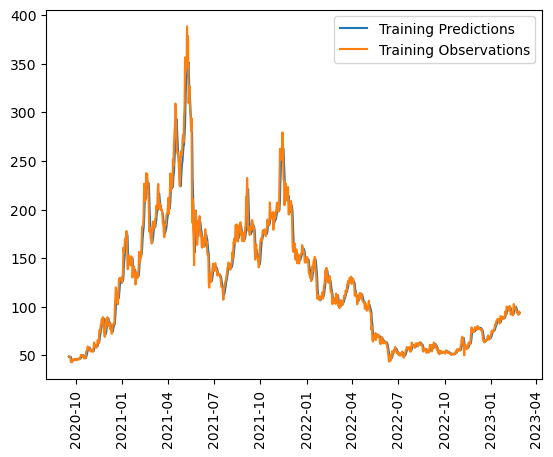

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0026055495254695415
Val MAE: 0.036011867225170135


5/5 [==============================] - 0s 2ms/step


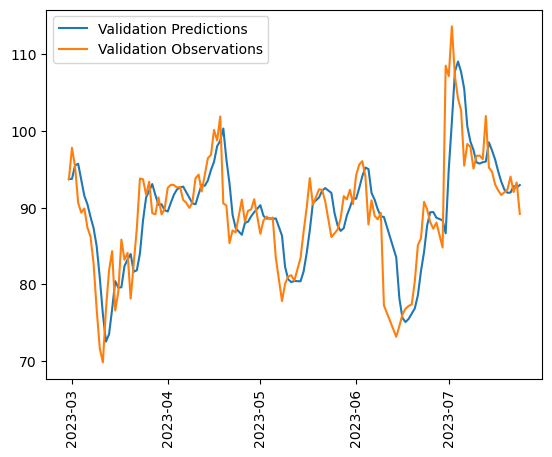

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0011774462182074785
Test MAE: 0.022822454571723938


4/4 [==============================] - 0s 2ms/step


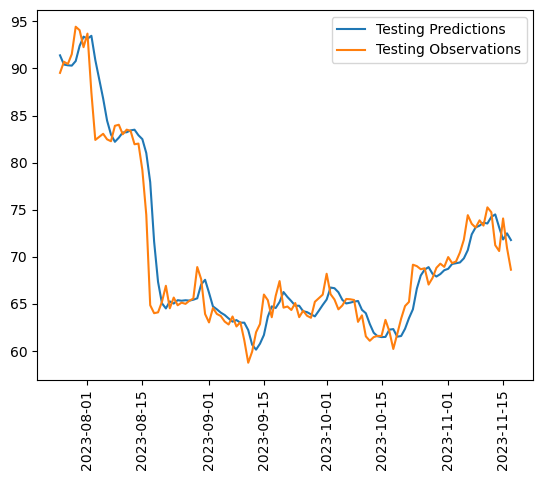

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9148215393558856


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 9ms/step
[4.3062863, 4.3064413, 4.305345, 4.304643, 4.304346, 4.304233, 4.3041844]
2023-11-18
2023-11-19
2023-11-20
2023-11-21
2023-11-22
2023-11-23
2023-11-24


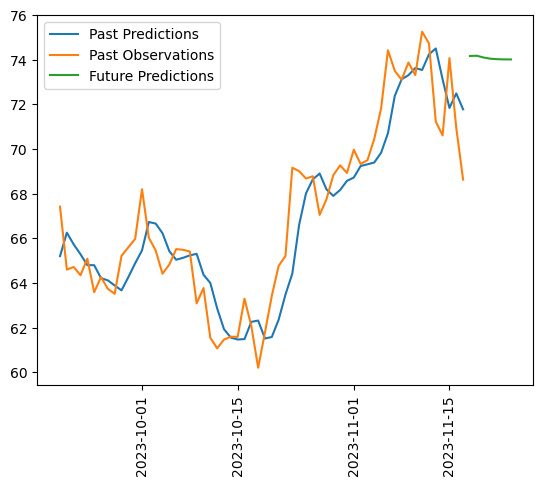

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-08-20,65.22,65.657074,64.964996,65.058807
2023-08-21,66.92,67.015190,65.868179,64.515373
2023-08-22,64.53,68.951164,67.970467,65.260201
2023-08-23,65.67,67.235886,66.058098,65.032532
2023-08-24,64.85,67.712418,66.841164,65.392685
...,...,...,...,...
2023-11-13,71.23,77.773430,76.816185,74.500641
2023-11-14,70.61,74.450386,73.268013,73.119507
2023-11-15,74.07,73.082176,72.325455,71.838722


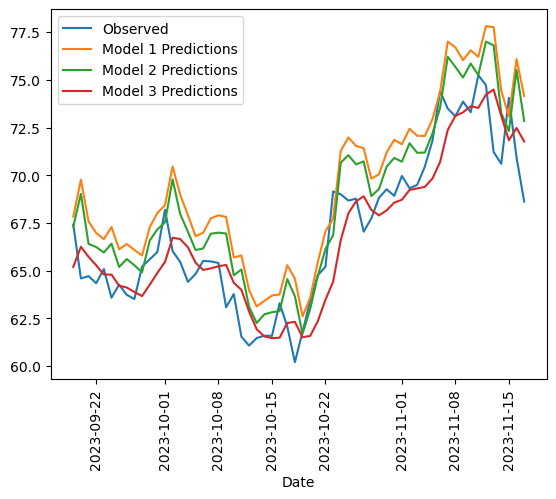

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.9012373910343793
Model 2 R2 Score:  0.895857404777081
Model 3 R2 Score:  0.9148215393558856
